# CNN 遥感图像分类项目

## 数据说明
This is a 21 class land use image dataset meant for research purposes. 
There are 100 images for each of the following classes:
+ agricultural
+ airplane
+ baseballdiamond
+ beach
+ buildings
+ chaparral
+ denseresidential
+ forest
+ freeway
+ golfcourse
+ harbor
+ intersection
+ mediumresidential
+ mobilehomepark
+ overpass
+ parkinglot
+ river
+ runway
+ sparseresidential
+ storagetanks
+ tenniscourt

Each image measures 256x256 pixels.

The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

Download site: http://weegee.vision.ucmerced.edu/datasets/landuse.html

## 项目任务

图像分类

1. 研读所提供代码 
2. 读取原始图像并进行预处理
3. 实现CNN architecture 
4. 在空白处完善代码

# 1. 读取原始数据和文件

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage.transform import resize
import cv2

from PIL import Image
import os
from shutil import copyfile

In [ ]:
#!pip freeze 

In [ ]:
print(keras.__version__)

In [ ]:
category_names = [
    'agricultural',
    'forest',
    'mobilehomepark',
    'overpass',
    'parkinglot',
    'river',
    'runway',
    'sparseresidential'
]

In [ ]:
num_images = 100  # per category
nb_classes = len(category_names)
patch_size = 256  # width and height in pixel
channels = 3

In [ ]:
# Load the numpy datasets
images_orig = np.load('data/UCMerced_images_orig_MultiClass.npy')
labels_num = np.load('data/UCMerced_labels_num_MultiClass.npy')

# Convert labels to categorical 'one hot encoded vector' --> required format for softmax cross-entropy loss.
# Create an array of zeros with length nb_classes and put a 1 at the index of the true label.
labels = to_categorical(labels_num, nb_classes)

print('Orginal Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels_num[i])

print('One-hot encoded Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels[i])

print('\nImages shape: {}'.format(images_orig.shape))
print('\nLabel shape: {}'.format(labels.shape))

# 2. Split train, val and test

In [ ]:
nb_images = images_orig.shape[0]
nb_images

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_orig, labels, 
                                                    test_size=0.2, 
                                                    stratify = labels, 
                                                    random_state=2021)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  stratify = y_train,
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

In [ ]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape,)

Check how many images per class in train/val/test

In [ ]:
def unique_counts(arr):
    unique, counts = np.unique(arr, axis=0, return_counts=True)
    unique_num = [np.where(r==1)[0][0] for r in unique] 
    print(dict(zip(unique_num, counts)))

In [ ]:
unique_counts(y_train)
unique_counts(y_val)
unique_counts(y_test)

# 3. Build CNN Base Model 

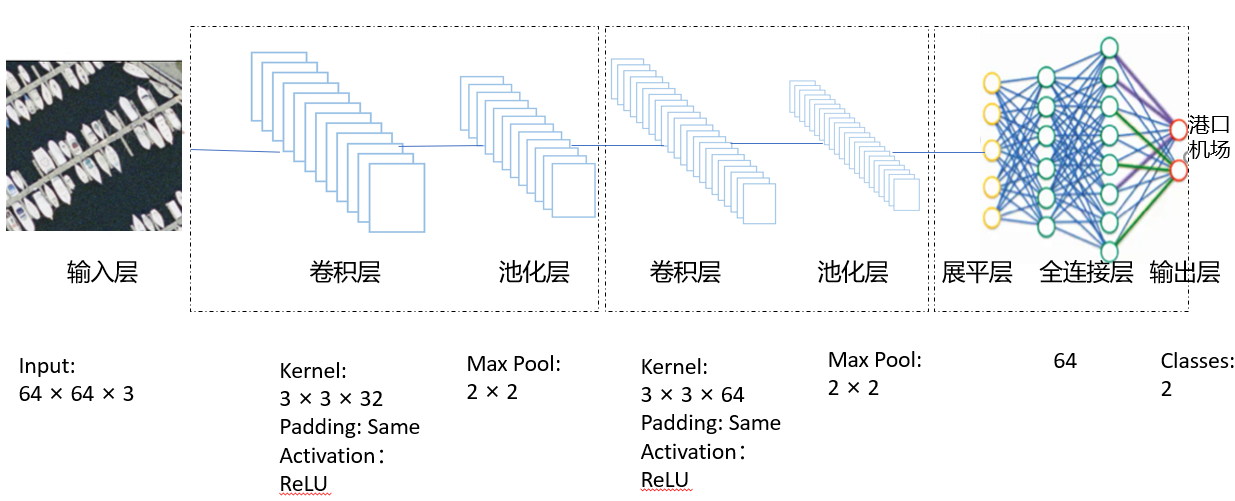

In [ ]:
# parameters:
input_shape = (int(patch_size/4), int(patch_size/4), channels)
pool_size = (2, 2)                  # size of pooling area for max pooling
prob_drop_hidden = 0.5              # drop probability for dropout @ dense layer

def define_CNN_base():

    model = Sequential()

    # conv1 layer
    model.add(Conv2D(filters=32, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                     input_shape=input_shape))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    # conv2 layer
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3),  
                     activation='relu', 
                     padding = 'same',
                   ))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2)))

    model.add(Flatten())

    # fc1 layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # The output of the model (softmax)
    model.add(Dense(nb_classes, activation='softmax'))
    return model

# clear the session first, such that layer names start with index 1
K.clear_session()
model_CNN_base = define_CNN_base()

In [ ]:
model_CNN_base.summary()

# 4. Train the base model

#### What is epoch
Number epoch equal to the number of times the algorithm sees the entire data set. So, each time the algorithm has seen all samples in the dataset, one epoch has completed.

#### What is batch size
Batch size is the number of items from the data to takes the training model. If you use the batch size of one you update weights after every sample. If you use batch size 32, you calculate the average error and then update weights every 32 items.

For instance, let’s say you have 24000 training samples and you want to set up a batch size equal to 32. The algorithm takes the first 32 samples from the training dataset and trains the network. Next, it takes the second 32 samples and trains the network again. We can keep doing this procedure until we have propagated all samples through the network.

#### What is iteration
Every time you pass a batch of data through the neural network, you completed one iteration. In the case of neural networks, that means the forward pass and backward pass. So, batch size * number of iterations = epoch

Iterative calculations on a portion of the data to save time and computational resources.

#### Epoch vs iteration
One epoch includes all the training examples whereas one iteration includes only one batch of training examples.


In general, a batch size of 32 is a good starting point, and you should also try with 64, 128, and 256. 

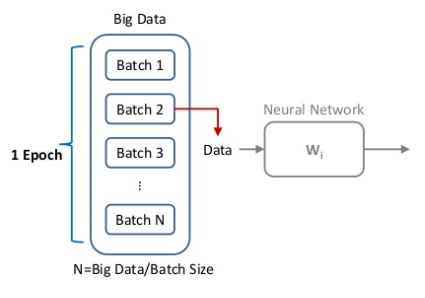

In [ ]:
# Set hyper parameters
epochs = 150
base_learning_rate=0.001
batch_size = 32

In [ ]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

In [ ]:
# set your architecture
model = define_CNN_base()

Compile the model with loss and the Adam optimizer.

In [ ]:
# Define an optimizer
opt = Adam(lr=base_learning_rate)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])       

In [ ]:
checkpoint_best_model = 'model/MultiClass_2Conv.hdf5'

# To monitor loss, mode min and set patience to 30 
es = EarlyStopping(monitor='<YOUR_CODE_HERE>', mode='<YOUR_CODE_HERE>', verbose=1, patience=<YOUR_CODE_HERE>)
# Use path defined above, and save best only 
mc = ModelCheckpoint(<YOUR_CODE_HERE>, monitor='val_accuracy', mode='max', verbose=1, save_best_only=<YOUR_CODE_HERE>)

Training commences by making a call to the fit method with our training and validation sets

In [ ]:
# Fit the model parameters
print('training...')

history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    verbose=2, 
                    validation_data=(X_val, y_val),                
                    callbacks=[<YOUR_CODE_HERE>, <YOUR_CODE_HERE>]
                   )

print('done')

Plotting training accuracy/loss curves

In [ ]:
def history_plot(model_id, history):
	plt.figure(figsize=(8,10)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

In [ ]:
history_plot('CNN_base', history)

#### Saving our model to disk

A Keras model consists of multiple components:

+ An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
+ A set of weights values (the "state of the model").
+ An optimizer (defined by compiling the model).
+ A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).
The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

+ Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
+ Saving the architecture / configuration only, typically as a JSON file.
+ Saving the weights values only. This is generally used when training the model.

In [ ]:
saved_model = load_model(checkpoint_best_model)

from datetime import datetime
DTime = datetime.now().strftime('%Y%m%d_%H%M%S')

_, acc = saved_model.evaluate(X_train, y_train, verbose=0)
print('Model evaluate on train, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_val, y_val, verbose=0)
print('Model evaluate on val, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
acc_test = round(100*acc,2)

save_file = checkpoint_best_model[0:-5] +'_' + DTime + '_ACC' + str(acc_test)+'.h5'
print("Model saved: ", save_file)
saved_model.save(save_file,  save_format="h5")

# 5. Prediction on test image

In [ ]:
# load the weights form the best epoch
model = saved_model

print('predicting...')
predictions = model.predict(x=X_test, batch_size=batch_size)

# convert predictions    
print('num. predictions: ', len(predictions))

In [ ]:
predictions[0]

In [ ]:
y_pred = to_categorical(np.argmax(predictions, axis=1), nb_classes)

In [ ]:
y_pred[0]

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score 
print("Macro")
print(precision_score(y_test, y_pred,average='macro'))
print(recall_score(y_test, y_pred,average='macro'))
print(f1_score(y_test, y_pred, average='macro'))
print("\nWeighted:")
print(precision_score(y_test, y_pred,average='weighted'))
print(recall_score(y_test, y_pred,average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# classification report
report_string = classification_report(y_test, y_pred, target_names=category_names)
print(report_string)

Input to confusion_matrix must be a vector of labels, not OHEs (one hot encodings). Call argmax on your y_test and y_pred

In [ ]:
# Confusion matrix
confmat = confusion_matrix( y_test.argmax(axis=1), predictions.argmax(axis=1))
confmat

In [ ]:
def plot_cm(y_true, y_pred, figsize=(12,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d/%d' % (c, s)
            elif c == 0:
                annot[i, j] = ''
            elif i<j:
                annot[i, j] = '%d' % (c)
            else:
                annot[i, j] = '%d' % (c)
    #cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm = pd.DataFrame(cm, index=category_names, columns=category_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"fontsize":12})
    
    

In [ ]:
plot_cm( y_test.argmax(axis=1), predictions.argmax(axis=1))

Have to convert into binary by using OneVsAll approach, so we'll have n_class number of ROC curves.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_score = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(nb_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], color='orange', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC - '+ category_names[i])
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
plt.figure(figsize=(10,10))

colors = ['aqua', 'darkorange', 'cornflowerblue','blue','orange','yellow','red','green']

for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# VISUALIZE IMAGES

import math

def plotImages_categories( images, labels, predictions, n_cols=4, figsize=(10, 10)):
    fig, axes = plt.subplots(math.ceil(len(images)/n_cols), n_cols, figsize=figsize)
    axes = axes.flatten()
    for i in range(math.ceil(len(images)/n_cols) * n_cols):
        axes[i].set_xticks(())
        axes[i].set_yticks(())
        
        if i < len(images):
            axes[i].imshow(images[i])
            if predictions is not None:
                title = 'LABEL:{}\nPRED: {}'.format(labels[i], predictions[i])

                if predictions[i] != labels[i]:
                    [j.set_linewidth(5) for j in axes[i].spines.values()]
                    [j.set_color('red') for j in axes[i].spines.values()]

            else:
                title = 'LABEL:{}'.format(labels[i])
            axes[i].set_title(title, fontdict={'family':'monospace'}, loc='left',fontsize = 12)
    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(len(category_names)):
    cat = []
    cat_pred = []
    X_test_cat = []
    for j in range(len(y_test)):
        if y_test.argmax(axis=1)[j] == i:
            cat.append(category_names[i])
            cat_pred.append(category_names[predictions.argmax(axis=1)[j]])
            X_test_cat.append(X_test[j])
    
    print('\nCategory:{}, Total Samples:{}'.format(category_names[i], len(cat)))
    
    plotImages_categories(images=X_test_cat, labels=cat,
                          predictions=cat_pred, 
                        figsize=(12, 16))